In [1]:
%load_ext autoreload
%autoreload 2

from ltu_ili_testing import GalaxySimulator, SBI_Fitter, calculate_muv

import numpy as np
import torch
from synthesizer.emission_models import PacmanEmission, TotalEmission, EmissionModel, IntrinsicEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist
from synthesizer.instruments import Instrument, FilterCollection, Filter
from unyt import Myr, erg, Hz, s

device = "cuda" 

Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0


### Setup Grid

In [2]:
grid_dir = '/home/tharvey/work/synthesizer_grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5'

grid = Grid(
    grid_name,
    grid_dir=grid_dir,
)

### Setup instrument

In [3]:
filter_codes = ["JWST/NIRCam.F090W","JWST/NIRCam.F115W","JWST/NIRCam.F150W","JWST/NIRCam.F162M",
                "JWST/NIRCam.F182M","JWST/NIRCam.F200W","JWST/NIRCam.F210M","JWST/NIRCam.F250M",
                "JWST/NIRCam.F277W","JWST/NIRCam.F300M","JWST/NIRCam.F335M","JWST/NIRCam.F356W",
                "JWST/NIRCam.F410M","JWST/NIRCam.F444W"]
filterset = FilterCollection(filter_codes)
instrument = Instrument('JWST', filters=filterset)

### Setup model

In [4]:
sfh = SFH.LogNormal
zdist = ZDist.DeltaConstant

### Setup Emission Model

In [5]:
emission_model = TotalEmission(
    grid=grid,
    fesc=0.1,
    fesc_ly_alpha=0.1,
    dust_curve=Calzetti2000(), 
    dust_emission_model=None,
)

# This tells the emission model we will have a parameter called 'tau_v' on the stellar emitter.
emitter_params = {'stellar':['tau_v']}

### Setup Photometry Simulator

Note the default is to return photometry, but you can return rest-frame fluxes, spectra
or observed spectra with output_type = 'fnu', 'photo_fnu', 'lnu' or 'photo_lnu' 

In [11]:
simulator = GalaxySimulator(
    sfh_model=sfh,
    zdist_model=zdist,
    grid=grid,
    instrument=instrument,
    emission_model=emission_model,
    emission_model_key='total',
    emitter_params=emitter_params,
    param_units = {'peak_age':Myr, 'max_age':Myr},
    normalize_method=None,#calculate_muv,
    output_type='photo_fnu',
    out_flux_unit='ABmag',
)

Now let's test it with an input dictionary

In [29]:
params = {'redshift': 6,
          'log_mass': 9.0,
          'tau': 0.4,
          'log10metallicity': -0.5,
          'peak_age': 100, 
          'max_age':800,
          'tau_v': 0.4,
          }


How fast is it?

In [15]:
%timeit simulator(params=params)

14.5 ms ± 92.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We're going to wrap the simulator in a small function which puts the input in the correct format (a Tensor of shape (1, *model.input_shape)) and then runs the simulator. To ensure we know the inputs, we will list them here.

In [9]:
inputs = ['redshift', 'log_mass', 'log10metallicity', 'tau_v', 'peak_age', 'max_age', 'tau']

def run_simulator(params, return_type='tensor'):
    if isinstance(params, torch.Tensor):
        params = params.cpu().numpy()

    if isinstance(params, dict):
        params = {i: params[i] for i in inputs}
    elif isinstance(params, (list, tuple, np.ndarray)):
        params = np.squeeze(params)
        params = {inputs[i]: params[i] for i in range(len(inputs))}


    phot = simulator(params)
    if return_type == 'tensor':
        return torch.tensor(phot[np.newaxis, :], dtype=torch.float32).to(device)
    else:
        return phot
    
run_simulator(params)

tensor([[ 0.2273, -0.1250, -0.2683, -0.2526, -0.2373, -0.2491, -0.2611, -0.3062,
         -0.5475, -0.6580, -0.7309, -0.6441, -0.5536, -0.6950, 27.4940]],
       device='cuda:0')

### Model

We should be able to either train purely online, or start with a grid and then continue
with online training. First we will test pure online training.

In [10]:
fitter = SBI_Fitter(
    name='online_test3',
    simulator=run_simulator,
    parameter_names=inputs,
    raw_photometry_names=simulator.instrument.filters.filter_codes+['norm'],    
)


Now we need to set our priors. 

In [111]:
priors = {
    'redshift': (5.0, 10.0),
    'log_mass': (7.0, 10.0),
    'log10metallicity': (-3.0, 0.3),
    'tau_v': (0.0, 1.5),
    'peak_age': (0, 500),
    'max_age': (500, 1000),
    'tau': (0.3, 1.5)
}

In [112]:
fitter.run_single_sbi(
    engine='SNPE',
    learning_type='online',
    override_prior_ranges=priors,
    num_simulations=10_000,
    num_online_rounds=7,
)

INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:The first round of inference will simulate from the given proposal or prior.


---------------------------------------------
Prior ranges:
---------------------------------------------
redshift: 5.00 - 10.00
log_mass: 7.00 - 10.00
log10metallicity: -3.00 - 0.30
tau_v: 0.00 - 1.50
peak_age: 0.00 - 500.00
max_age: 500.00 - 1000.00
tau: 0.30 - 1.50
---------------------------------------------


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 1 / 7
INFO:root:Training model 1 / 1.


 Neural network successfully converged after 665 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 2 / 7
INFO:root:Training model 1 / 1.


Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 3 / 7
INFO:root:Training model 1 / 1.


Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 4 / 7
INFO:root:Training model 1 / 1.


Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 5 / 7
INFO:root:Training model 1 / 1.


Using SNPE-C with atomic loss
 Neural network successfully converged after 101 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 6 / 7
INFO:root:Training model 1 / 1.


Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 7 / 7
INFO:root:Training model 1 / 1.


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 19

INFO:root:It took 1516.8163268566132 seconds to train models.
INFO:root:Saving model to /home/tharvey/work/ltu-ili_testing/models/online_test3


 Neural network successfully converged after 20 epochs.Time to train model(s): 0:27:11.877420
No plots for online learning yet.


(NeuralPosteriorEnsemble sampler for potential_fn=<EnsemblePotential>,
 [{'epochs_trained': [0, 665, 62, 65, 57, 101, 34, 20],
   'best_validation_log_prob': [-inf,
    -7.166033098774571,
    -0.04501848070011023,
    -0.059183542286196066,
    -0.07380226325243712,
    -0.035815192822319195,
    -0.036183992042181326,
    -0.05103839204193802],
   'validation_log_probs': [-18.01763349963773,
    -17.672923118837417,
    -17.051265716552734,
    -16.080871735849687,
    -15.263540852454401,
    -14.63414672113234,
    -14.068296647840931,
    -13.649940552250031,
    -13.296839837105043,
    -13.006808373235888,
    -12.824978982248615,
    -12.689853360576015,
    -12.550976599416424,
    -12.397111523535944,
    -12.247308854133852,
    -12.140120598577685,
    -12.041636528507356,
    -11.952117950685563,
    -11.877915351621565,
    -11.825820984378938,
    -11.728954807404548,
    -11.649573110765026,
    -11.59206901058074,
    -11.520088626492408,
    -11.466704583937123,
    -

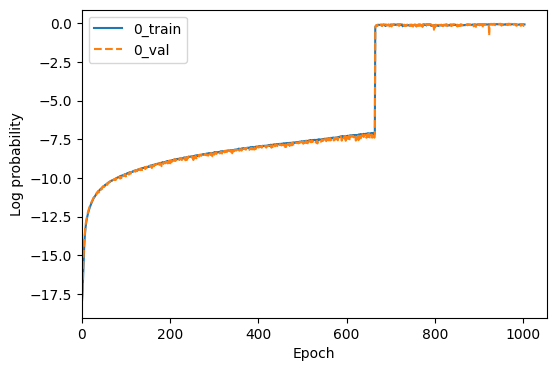

In [113]:
fitter.plot_loss()

In [98]:
fitter.run_validation_from_file('/home/tharvey/work/ltu-ili_testing/models/online_test/online_test_20250512_174838_posterior.pkl')

AttributeError: 'list' object has no attribute 'values'

Optuna parameter optimization

In [117]:
name = 'online_optuna'

suggested_hyperparameters = {
    "learning_rate": [1e-6, 1e-3],
    "hidden_features": [12, 200],
    "num_components": [2, 16],
    "training_batch_size": [32, 128],
    "num_transforms": [1, 4],
    "stop_after_epochs": [10, 30],
    "clip_max_norm": [0.1, 5.0],
    "validation_fraction": [0.1, 0.3],
    "num_online_rounds":[5, 10],
    "num_simulations":[8000, 30000],
}

fixed_hyperparameters = {
    'engine':'SNPE',
    'learning_type':'online',
    'override_prior_ranges': priors,

}

In [118]:
fitter.optimize_sbi(study_name=name,
                    n_jobs=6,
                    n_trials=20,
                    suggested_hyperparameters=suggested_hyperparameters,
                    fixed_hyperparameters=fixed_hyperparameters,
)


[I 2025-05-13 00:54:01,263] A new study created in memory with name: online_optuna


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:The first round of inference will use existing sims from the loader. Make sure that the simulations were run from the given proposal distribution for consistency.
INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:Running round 1 / 6
INFO:root:The first round of inference will use existing sims from the loader. Make sure that the simulations were run from the given proposal distribution for consistency.
INFO:root:Running round 1 / 7
INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:The first round of inference will use existing sims from the loader. Make sure that the simulations were run from the given proposal distribution for consistency.
INFO:root:Running round 1 / 10
INFO:root:Training model 1 / 1.
INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:Training model 1 / 1.
INFO:root:The first round of inference will use existing sims from the loader. Make sure that the simulations were run from the given proposal distribution for consistency.
I

Drawing 9133 posterior samples:   0%|          | 0/9133 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    9133 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 

[W 2025-05-13 01:31:12,566] Trial 4 failed with parameters: {'learning_rate': 1.4354173103036904e-05, 'hidden_features': 197, 'num_components': 14, 'training_batch_size': 114, 'num_transforms': 3, 'stop_after_epochs': 13, 'clip_max_norm': 1.4726167284707812, 'validation_fraction': 0.21013325843329939, 'num_online_rounds': 10, 'num_simulations': 9133} because of the following error: RuntimeError('Error during SBI training: Socket operation on non-socket').
Traceback (most recent call last):
  File "/home/tharvey/work/ltu-ili_testing/.venv/lib/python3.11/site-packages/tqdm/notebook.py", line 262, in update
    return super().update(n=n)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/tharvey/work/ltu-ili_testing/.venv/lib/python3.11/site-packages/tqdm/std.py", line 1242, in update
    self.refresh(lock_args=self.lock_args)
  File "/home/tharvey/work/ltu-ili_testing/.venv/lib/python3.11/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/tharvey/work/ltu-ili_te

In [20]:
fitter.load_model_from_pkl('/home/tharvey/work/ltu-ili_testing/models/online_test3');

In [19]:
fitter.plot_coverage(sample_method='vi')

[[ 2.4592502e+00  1.4660654e-02 -5.6663960e-01 ... -3.0903480e+00
  -3.1637781e+00  3.5620998e+01]
 [ 8.9222136e+00  1.0772885e-01 -1.7073953e-01 ... -1.0565397e+00
  -1.0360785e+00  2.7714869e+01]
 [ 9.7719684e-02 -1.8571462e-01 -4.3378800e-01 ... -1.6999210e+00
  -1.9013221e+00  3.2463234e+01]
 ...
 [ 2.1951230e+00 -3.6145397e-02 -3.3548510e-01 ... -1.4439768e+00
  -1.4279387e+00  3.0491447e+01]
 [ 4.4873341e+01  2.7199308e+01 -2.0471867e-02 ... -8.3861500e-01
  -9.8825091e-01  2.9436861e+01]
 [ 4.1627769e+00  1.1988749e-02 -1.5333916e-01 ... -1.7934562e+00
  -1.5804826e+00  3.2851936e+01]] [[ 6.8449111e+00  7.3439078e+00 -1.8950931e+00 ...  3.9064752e+02
   5.3085718e+02  4.1122591e-01]
 [ 7.6829295e+00  9.4480476e+00 -8.8117552e-01 ...  3.1391672e+02
   7.9961212e+02  1.2504472e+00]
 [ 5.7836404e+00  7.9640417e+00 -1.6234159e-01 ...  1.7919519e+02
   6.4709448e+02  1.4282191e+00]
 ...
 [ 7.0247564e+00  8.5232811e+00 -6.3198495e-01 ...  1.0524083e+02
   8.6968091e+02  4.0726063e-01]

  0%|          | 0/1000 [00:00<?, ?it/s]

[2025-05-13 12:31:17,672] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


  2%|▏         | 15/1000 [01:04<1:10:54,  4.32s/it]


KeyboardInterrupt: 

Let's do a very simple model with just metallicity and dust. 


In [34]:
inputs = ['log10metallicity', 'tau_v']
fixed_params = {
    'redshift':7,
    'log_mass': 9.0,
    'peak_age': 100,
    'max_age':800,
    'tau': 0.7,
}

priors = {
    'log10metallicity': (-3.0, -1.3),
    'tau_v': (0.0, 2),
}

simulator = GalaxySimulator(
    sfh_model=sfh,
    zdist_model=zdist,
    grid=grid,
    instrument=instrument,
    emission_model=emission_model,
    emission_model_key='total',
    emitter_params=emitter_params,
    param_units = {'peak_age':Myr, 'max_age':Myr},
    normalize_method=None,#calculate_muv,
    output_type='photo_fnu',
    out_flux_unit='ABmag',
    fixed_params=fixed_params,
)

def run_simulator(params, return_type='tensor'):
    if isinstance(params, torch.Tensor):
        params = params.cpu().numpy()

    if isinstance(params, dict):
        params = {i: params[i] for i in inputs}
    elif isinstance(params, (list, tuple, np.ndarray)):
        params = np.squeeze(params)
        params = {inputs[i]: params[i] for i in range(len(inputs))}


    phot = simulator(params)
    if return_type == 'tensor':
        return torch.tensor(phot[np.newaxis, :], dtype=torch.float32).to(device)
    else:
        return phot


run_simulator(params)

fitter = SBI_Fitter(
    name='online_dust_zmet_test',
    simulator=run_simulator,
    parameter_names=inputs,
    raw_photometry_names=simulator.instrument.filters.filter_codes+['norm'],    
)


In [35]:
fitter.run_single_sbi(
    engine='SNPE',
    learning_type='online',
    override_prior_ranges=priors,
    num_simulations=10_000,
    num_online_rounds=1,
)

INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:The first round of inference will simulate from the given proposal or prior.


/home/tharvey/work/ltu-ili_testing/models/online_dust_zmet_test/online_dust_zmet_test_20250523_173246_params.pkl
---------------------------------------------
Prior ranges:
---------------------------------------------
log10metallicity: -3.00 - -1.30
tau_v: 0.00 - 2.00
---------------------------------------------
Drawing random photometry from prior to conditon on. Results probably won't generalize well.
Creating mdn network with SNPE engine and sbi backend.
     hidden_features: 50
     num_components: 4


454072 detected dead process, and making mutex /rocm_smi_card1 consistent.


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 1 / 1
INFO:root:Training model 1 / 1.


[2025-05-23 17:35:59,694] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 Training neural network. Epochs trained: 334

INFO:root:It took 112.73405909538269 seconds to train models.
INFO:root:Saving model to /home/tharvey/work/ltu-ili_testing/models/online_dust_zmet_test


 Neural network successfully converged after 335 epochs.Time to train model(s): 0:05:05.457652
No plots for online learning yet.


(EnsemblePosterior sampler for potential_fn=<EnsemblePotential>,
 [{'epochs_trained': [0, 335],
   'best_validation_loss': [inf, -5.030523223261679],
   'validation_loss': [1.4635491678791661,
    0.9175484891860716,
    0.02999973795827358,
    -0.5087130098573623,
    -0.8175294687671046,
    -0.9944282635565727,
    -1.1455702147176188,
    -1.2723185631536669,
    -1.343737256142401,
    -1.4069359725521458,
    -1.523271837542134,
    -1.5964052100335397,
    -1.664781358934218,
    -1.707068012606713,
    -1.7642050943066996,
    -1.7906937291545253,
    -1.8647662824200046,
    -1.9205745189420638,
    -1.968779698494942,
    -2.010423514150804,
    -2.04970754731086,
    -1.9883530178377706,
    -2.0714216386118243,
    -2.1895492999784407,
    -2.2297054260007796,
    -2.2681823776614283,
    -2.2302576457300494,
    -2.3821187250075804,
    -2.4447238906737296,
    -2.4127887833502983,
    -2.4644799540119786,
    -2.562321739812051,
    -2.581794277314217,
    -2.66244791400

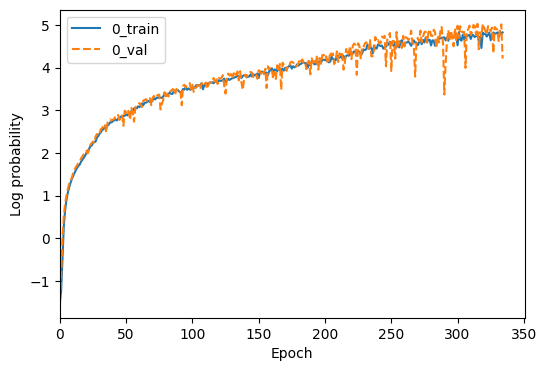

In [36]:
fitter.plot_loss()

100%|██████████| 1000/1000 [00:01<00:00, 502.17it/s]
INFO:root:Saving coverage plot to /home/tharvey/work/ltu-ili_testing/models/online_dust_zmet_test/plots/plot_coverage.jpg...
INFO:root:Saving ranks histogram to /home/tharvey/work/ltu-ili_testing/models/online_dust_zmet_test/plots/ranks_histogram.jpg...
INFO:root:Mean logprob: 4.7900e+00Median logprob: 4.9339e+00
INFO:root:Saving true logprobs to /home/tharvey/work/ltu-ili_testing/models/online_dust_zmet_test/plots/true_logprobs.npy...
INFO:root:Saving true logprobs plot to /home/tharvey/work/ltu-ili_testing/models/online_dust_zmet_test/plots/plot_true_logprobs.jpg...
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
100%|██████████| 100/100 [00:03<00:00, 29.74it/s]


[<Figure size 800x400 with 2 Axes>,
 <Figure size 600x400 with 2 Axes>,
 <Figure size 800x400 with 2 Axes>,
 (<Figure size 600x400 with 1 Axes>,
  array([  4.85657523,   4.89716526,   4.29051202,   4.8624285 ,
           5.07817182,   5.78552713,   5.95610825,   5.34622633,
           5.67241505,   4.49795799,   4.98125908,   4.96775563,
           5.46916399,   4.77806922,  -3.90479204,   3.79705191,
           5.57778346,   3.52876437,   5.59370642,   5.06528654,
          -8.49434549,   4.33441597,   2.23421674,   6.16848709,
           5.14111189,   3.52622162,   4.90180481,   4.70988393,
           5.13059824,   6.04600192,   5.43116635,   5.41978283,
           4.56913474,   3.45657124,   4.86909116,   4.90541464,
           4.93111075,   5.08604972,   5.44069476,   6.41429902,
           5.23926844,   4.65235619,   4.62189349,   4.53886351,
           5.68359166,   2.87997162,   3.18799597,   3.35299335,
           5.17228512,   4.9382567 ,   3.0613565 ,   5.13797075,
          

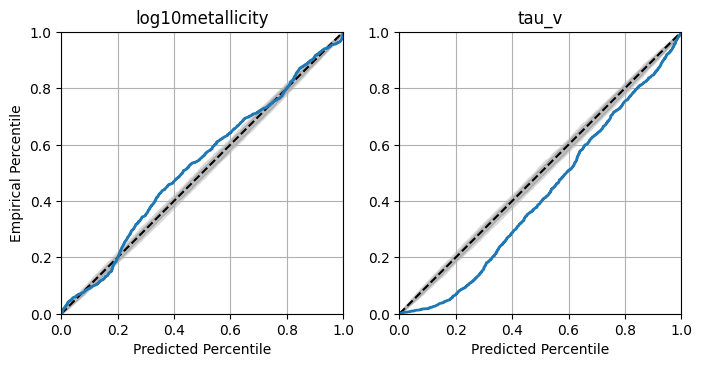

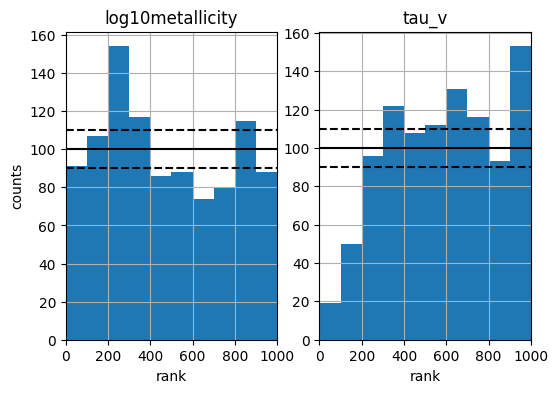

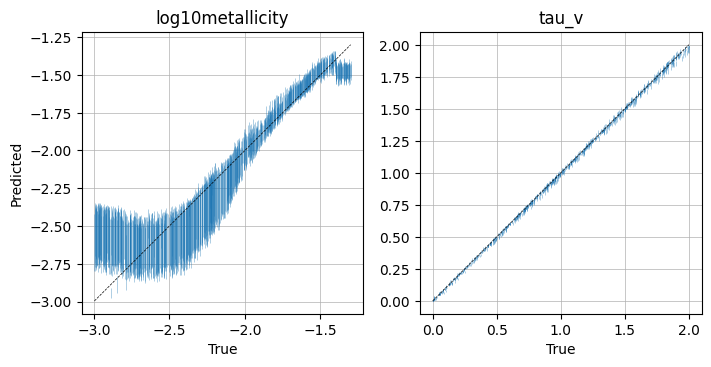

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


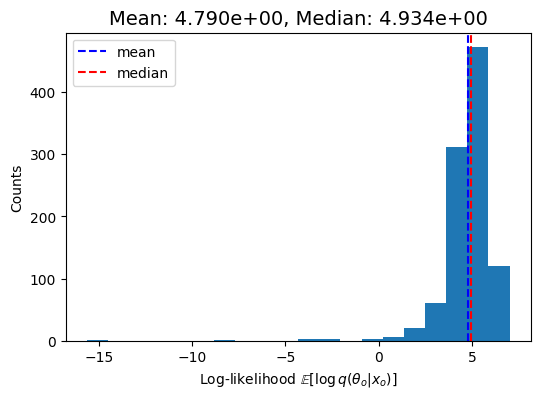

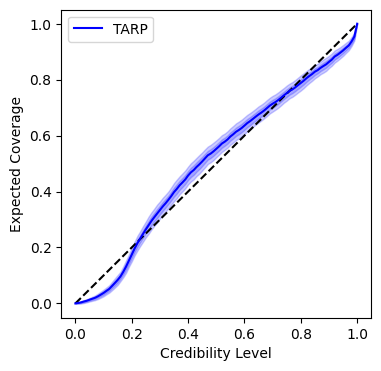

In [37]:
fitter.plot_coverage()

What about just SFH?

INFO:root:MODEL INFERENCE CLASS: SNPE
INFO:root:The first round of inference will simulate from the given proposal or prior.


/home/tharvey/work/ltu-ili_testing/models/online_sfh_lognorm_test/online_sfh_lognorm_test_20250523_174246_params.pkl
---------------------------------------------
Prior ranges:
---------------------------------------------
peak_age: 0.00 - 500.00
max_age: 500.00 - 1000.00
tau: 0.10 - 2.00
---------------------------------------------
Drawing random photometry from prior to conditon on. Results probably won't generalize well.
Creating mdn network with SNPE engine and sbi backend.
     hidden_features: 50
     num_components: 4


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Running round 1 / 1
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 431

INFO:root:It took 145.37906646728516 seconds to train models.
INFO:root:Saving model to /home/tharvey/work/ltu-ili_testing/models/online_sfh_lognorm_test


 Neural network successfully converged after 432 epochs.Time to train model(s): 0:06:43.495547
No plots for online learning yet.


100%|██████████| 1000/1000 [00:02<00:00, 425.21it/s]
INFO:root:Saving coverage plot to /home/tharvey/work/ltu-ili_testing/models/online_sfh_lognorm_test/plots/plot_coverage.jpg...
INFO:root:Saving ranks histogram to /home/tharvey/work/ltu-ili_testing/models/online_sfh_lognorm_test/plots/ranks_histogram.jpg...
INFO:root:Mean logprob: -8.3898e+00Median logprob: -8.4692e+00
INFO:root:Saving true logprobs to /home/tharvey/work/ltu-ili_testing/models/online_sfh_lognorm_test/plots/true_logprobs.npy...
INFO:root:Saving true logprobs plot to /home/tharvey/work/ltu-ili_testing/models/online_sfh_lognorm_test/plots/plot_true_logprobs.jpg...
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
100%|██████████| 100/100 [00:04<00:00, 23.42it/s]


[<Figure size 1200x400 with 3 Axes>,
 <Figure size 900x400 with 3 Axes>,
 <Figure size 1200x400 with 3 Axes>,
 (<Figure size 600x400 with 1 Axes>,
  array([-11.78242034,  -7.38513016,  -8.56950018,  -9.56154381,
          -8.65193714,  -5.66022405, -11.16165088,  -6.60920659,
          -9.19361157,  -7.47682601,  -6.2802029 ,  -6.01217033,
          -9.87233377,  -6.03543907,  -9.52349312, -10.79946294,
          -5.39011668,  -7.05088699,  -7.8434147 ,  -7.79411723,
          -9.45399583,  -7.22062502,  -7.59107611,  -8.94820477,
         -10.57570897, -10.22966232,  -8.28379768,  -6.89424212,
          -7.88286127, -10.75460699,  -6.18054193,  -7.39114464,
          -9.63363415,  -8.65420054,  -8.32927742,  -9.05221369,
          -9.42022923,  -8.65982647,  -9.8033168 ,  -6.54210573,
          -8.23923318,  -8.81863275,  -8.47922764,  -9.24606137,
          -6.10662184,  -8.91335015,  -9.74623975,  -9.362548  ,
         -10.40858866,  -7.70925722, -10.46238133,  -6.98706949,
        

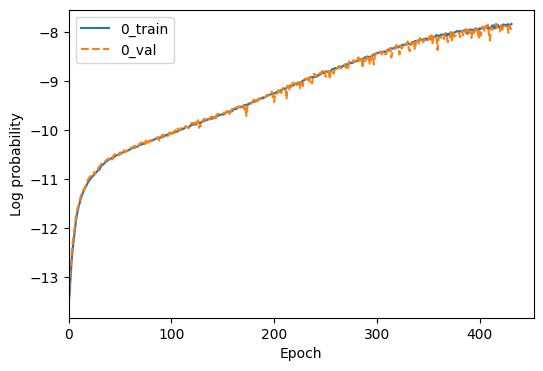

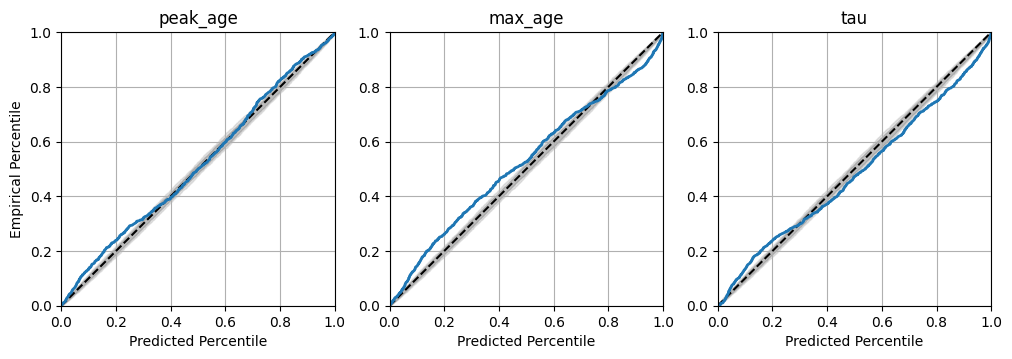

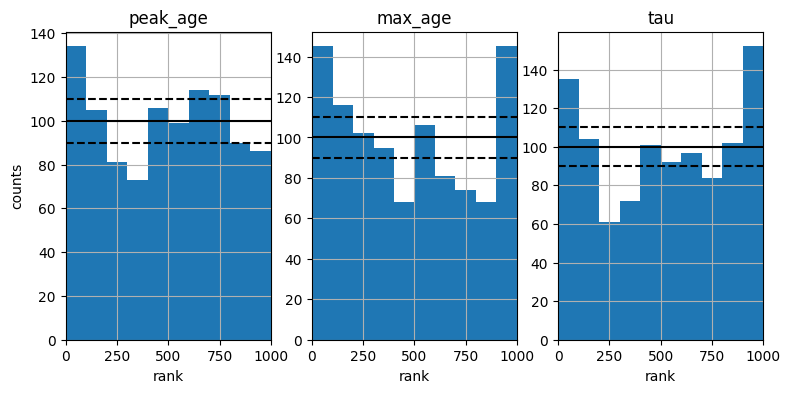

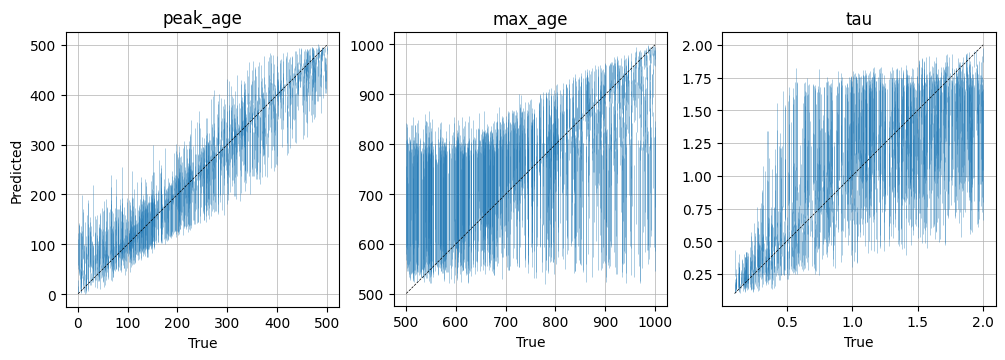

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


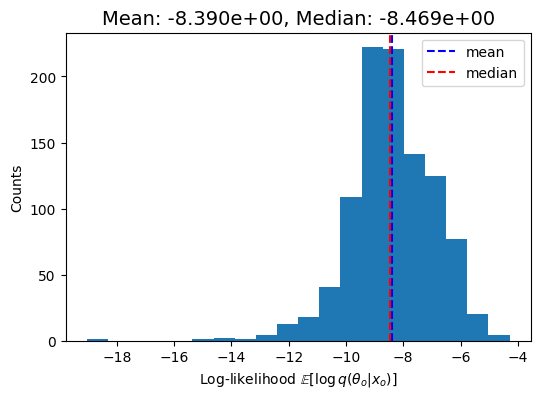

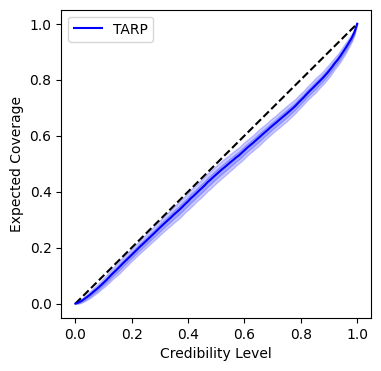

In [38]:
inputs = ['peak_age','max_age', 'tau']

fixed_params = {
    'redshift':7,
    'log_mass': 9.0,
    'log10metallicity': -2,
    'tau_v':0.3,
}

priors = {
    'peak_age': (0, 500),
    'max_age': (500, 1000),
    'tau': (0.1, 2)
}

simulator = GalaxySimulator(
    sfh_model=sfh,
    zdist_model=zdist,
    grid=grid,
    instrument=instrument,
    emission_model=emission_model,
    emission_model_key='total',
    emitter_params=emitter_params,
    param_units = {'peak_age':Myr, 'max_age':Myr},
    normalize_method=None,#calculate_muv,
    output_type='photo_fnu',
    out_flux_unit='ABmag',
    fixed_params=fixed_params,
)

def run_simulator(params, return_type='tensor'):
    if isinstance(params, torch.Tensor):
        params = params.cpu().numpy()

    if isinstance(params, dict):
        params = {i: params[i] for i in inputs}
    elif isinstance(params, (list, tuple, np.ndarray)):
        params = np.squeeze(params)
        params = {inputs[i]: params[i] for i in range(len(inputs))}


    phot = simulator(params)
    if return_type == 'tensor':
        return torch.tensor(phot[np.newaxis, :], dtype=torch.float32).to(device)
    else:
        return phot


fitter = SBI_Fitter(
    name='online_sfh_lognorm_test',
    simulator=run_simulator,
    parameter_names=inputs,
    raw_photometry_names=simulator.instrument.filters.filter_codes+['norm'],    
)

fitter.run_single_sbi(
    engine='SNPE',
    learning_type='online',
    override_prior_ranges=priors,
    num_simulations=10_000,
    num_online_rounds=1,
)

fitter.plot_loss()

fitter.plot_coverage()